# Method1 SVD+Huffman

### Code

#### Import the EDF file
Installation: https://mne.tools/dev/install/mne_python.html

Function description: https://mne.tools/dev/generated/mne.io.read_raw_edf.html

#### #Convert the edf file into csv and reload the csv file

If we just use raw_data[0], just as the we mentioned above, this step will not be needed anymore

In [1]:
import numpy as np

In [2]:
import pandas as pd
eda = pd.read_csv('EDA.csv')

In [3]:
eda

,1563898771.000000
0,4.000000
1,0.000000
2,0.003842
3,0.021772
4,0.026895
...,...
9074,0.006404
9075,0.006404
9076,0.006404
9077,0.008965


In [4]:
eda = eda.iloc[1:]

In [5]:
np.savetxt('eda.txt',eda)

#### Plot the signal to explore the data

In [6]:
sampling_freq = 1/4 #This is the sampling frequency
N = eda.size  #The number of point
N

9078

In [7]:
index = np.linspace(0, round((N-1)*sampling_freq,4), N) #Set the time sequence for the signal
index

array([0.00000e+00, 2.50000e-01, 5.00000e-01, ..., 2.26875e+03,
       2.26900e+03, 2.26925e+03])

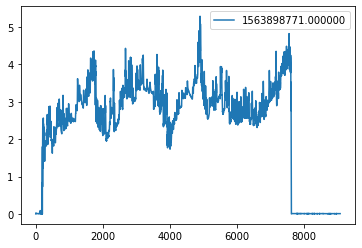

In [8]:
eda.plot()

In [9]:
eda_array = eda.to_numpy() #save the data into an ndarray
eda_array.size

9078

#### Truncate the signal 
Get rid of the first 3mins and last 5mins

In [10]:
eda_array = eda_array[0:7700]  # Remove the signal in first 3minutes and last 5minutes

In [11]:
eda_array.size

7700

In [12]:
sampling_freq = 1/4
N = eda_array.size

In [13]:
index = np.linspace(0, round((N-1)*sampling_freq,4), N)
index

array([0.00000e+00, 2.50000e-01, 5.00000e-01, ..., 1.92425e+03,
       1.92450e+03, 1.92475e+03])

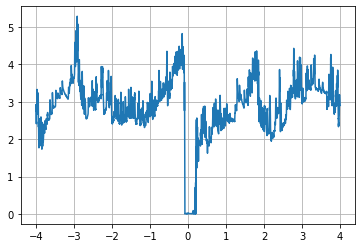

In [14]:
from scipy.fft import fft,fftshift
# Number of sample points

y = eda_array
yf = fft(y)
yf = fftshift(yf)
xf = np.linspace(-1/sampling_freq, 1/sampling_freq, N)
import matplotlib.pyplot as plt
plt.plot(xf, np.abs(yf))
#plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

#### Butterworth Band pass Filter

In [15]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

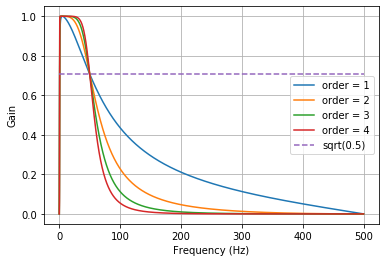

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 1000.0
lowcut = 0.5
highcut = 50.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [1, 2, 3, 4]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

#### SVD

In [17]:
eda_array.shape

(7700, 1)

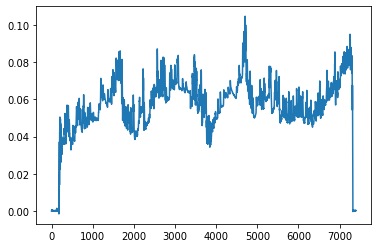

In [18]:
from scipy import signal
y = butter_bandpass_filter(eda_array, lowcut, highcut, fs, order=2)
resampled_signal = signal.resample(y,7396 )  #This squared number need to be decided by the users
plt.plot(resampled_signal)
plt.show()

In [20]:
from scipy import linalg
reshaped_signal = np.reshape(resampled_signal, (86,86))
U, s, Vh = linalg.svd(reshaped_signal)
print(reshaped_signal.shape)
print(U.shape)
print(s.shape)
print(Vh.shape)

(86, 86)
(86, 86)
(86,)
(86, 86)


#### Reconstruct the original matrix from the decomposition
For future decoding

In [22]:
# Kernal need 
#m = 347
#n = 347
#sigma = np.zeros((m, n))
#for i in range(min(m, n)):
#    sigma[i, i] = s[i]
#reconstructed_signal = np.dot(U, np.dot(sigma, Vh))
#reshaped_recon_signal = np.reshape(reconstructed_signal,120409)
#np.allclose(reshaped_recon_signal, normalized_signal)
#True means the signal could be reconstructed back to the original one

#### Quantization

In [21]:
round_U = np.around(U,4) #Keep four decimals
print(round_U)
unique, counts = np.unique(round_U, return_counts=True)
U_dict = dict(zip(unique, counts))
unique.size

[[ 4.000e-04  3.100e-03  4.000e-04 ...  2.364e-01 -6.421e-01  4.550e-02]
 [ 3.000e-04  2.000e-04  8.000e-04 ... -1.538e-01  2.338e-01 -3.190e-02]
 [ 5.670e-02 -4.733e-01  2.407e-01 ... -8.000e-03 -4.700e-03 -2.100e-03]
 ...
 [ 1.501e-01  1.900e-03 -4.920e-02 ... -9.400e-03  3.630e-02  7.860e-02]
 [ 1.516e-01  4.720e-02  2.558e-01 ...  1.280e-02 -1.540e-02 -1.720e-02]
 [ 9.900e-03  4.674e-01 -2.955e-01 ...  1.320e-02  3.240e-02  2.060e-02]]


3385

In [22]:
np.savetxt('eda_U_round4.txt',round_U,fmt='%.3f')

#### INSTRUCTION ON HOW TO COMPRESS THE DATA BY HUFFMAN CODING


(I used the package "tcmpr 0.2" and "pyhuff 1.1". These two packages provided the same compression result. So here, we just use "tcmpr 0.2")

1. Open your termial or git bash, enter "pip install tcmpr" to install the "tcmpr 0.2" package
2. Enter the directory which include the file you want to compress OR copy the path of the file you want to compress
3. Enter "tcmpr <filename>.txt" / "tcmpr <filepath>" to compress the file
4. Find the compressed file in the same directory of the original file



1. The file size(round 4) before Huffman coding is 48KB. The file size(round 4) after Huffman coding is 19kB



Also do this step for "s" and "Vh"

In [23]:
round_s = np.around(s,4)
unique, counts = np.unique(round_s, return_counts=True)
U_dict = dict(zip(unique, counts))
unique.size

72

In [24]:
np.savetxt('eda_s_round4.txt',round_s,fmt='%.3f')

"s" can be shrank from 516bytes to 351bytes

In [25]:
round_Vh = np.around(Vh,4)
#print(round_s)
unique, counts = np.unique(round_Vh, return_counts=True)
U_dict = dict(zip(unique, counts))
unique.size

3463

In [26]:
np.savetxt('eda_Vh_round4.txt',round_Vh,fmt='%.3f')

"Vh" can be shrank from 48kB to 20kB

In conclusion, the size of the original data in csv is 82kB. In txt file, the size of the original data is 227kB. After compression, the size of the U, s, and Vh is 19kB, 0.5KB, and 20kB. The compression ratio is 5.74.
It seems that the compression result is not so ideal as we supposed. Also, the SVD decomposed the data into 3 matrices, but it actually expand the size/length of the data. So I was thinking.....

#### PRD calculation

In [27]:
decoded_data_U = np.loadtxt(fname = "eda_U_round4.txt") #Cuz Huffman coding is lossless coding, so it's fine to use this txt file
decoded_data_s = np.loadtxt(fname = "eda_s_round4.txt")
decoded_data_Vh = np.loadtxt(fname = "eda_Vh_round4.txt")
#decoded_data_U =decoded_data_U[..., np.newaxis]
#decoded_data_s =decoded_data_s[..., np.newaxis]
#decoded_data_Vh =decoded_data_Vh[..., np.newaxis]

In [28]:
s.shape

(86,)

In [29]:
# Kernal need 
m = 86
n = 86
sigma = np.zeros((m, n))
for i in range(min(m, n)):
    sigma[i, i] = decoded_data_s[i]
reconstructed_signal = np.dot(decoded_data_U, np.dot(sigma, decoded_data_Vh))
deSVD = np.reshape(reconstructed_signal,7396)
#np.allclose(reshaped_recon_signal, normalized_signal)
#True means the signal could be reconstructed back to the original one

In [30]:
deSVD.shape

(7396,)

In [34]:
deSVD = deSVD[..., np.newaxis]
resampled_signal.shape

(7396, 1)

In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import signal
# original_signal = normalized_signal
# compressed_signal = decoded_data
def PRD_calculation(original_signal, compressed_signal):
    PRD = sqrt(sum((original_signal-compressed_signal)**2)/(sum(original_signal**2)))
    return PRD

PRD = PRD_calculation(resampled_signal, deSVD)
print("The PRD is {}%".format(round(PRD*100,3)))

The PRD is 0.39%


### What if I don't do SVD? Just compress the signal directly...

In [38]:
round_signal = np.around(resampled_signal,3) #round it with 2 decimals will be good
#Cuz keep only 1 decimal will lose a lot of information, and keep 3 decimals will be redundant 
#and the compression ratio will not be good.
print(round_signal)
unique, counts = np.unique(round_signal, return_counts=True)
U_dict = dict(zip(unique, counts))
unique.size

[[-0.]
 [ 0.]
 [ 0.]
 ...
 [ 0.]
 [ 0.]
 [ 0.]]


90

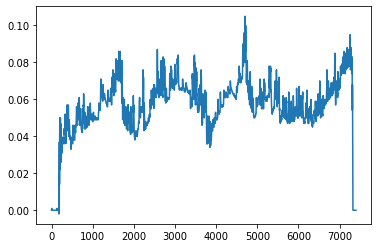

In [39]:
plt.plot(round_signal)
plt.show()

In [40]:
np.savetxt('eda_signal_rounded.txt',round_signal,fmt='%.3f')

In [42]:
decoded_data = np.loadtxt(fname = "eda_signal_rounded.txt")

In [43]:
decoded_data

array([-0.,  0.,  0., ...,  0.,  0.,  0.])

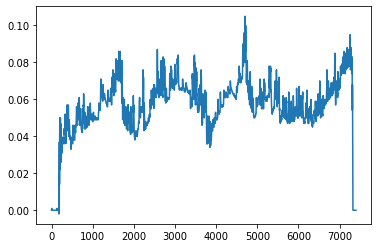

In [44]:
plt.plot(decoded_data)
plt.show()

In [45]:
decoded_data.shape

(7396,)

Use Huffman coding to encode this normalized signal sequence.

Before Huffman coding, the size of the txt file of this signal sequence is 44kB. After Huffman coding, the size of the txt file of this signal sequence is 16kB.

The original size of the raw data is 82kB in csv and 227kb in txt. If we calculate the compression ratio by the same data format. The compression ratio is 12.34


In [46]:
resampled_signal.shape

(7396, 1)

In [37]:
resampled_signal

array([[ 1.26359797e+00],
       [-2.77797510e-03],
       [ 1.58258330e-03],
       ...,
       [ 4.47325955e+00],
       [ 4.03357800e+00],
       [ 3.45578605e+00]])

In [47]:
decoded_data

array([-0.,  0.,  0., ...,  0.,  0.,  0.])

In [48]:
decoded_data =decoded_data[..., np.newaxis]
decoded_data

array([[-0.],
       [ 0.],
       [ 0.],
       ...,
       [ 0.],
       [ 0.],
       [ 0.]])

#### PRD calculation:


In [42]:
#resampled_signal_ori = signal.resample(ECG_array, 564001)

In [49]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import signal
# original_signal = normalized_signal
# compressed_signal = decoded_data
def PRD_calculation(original_signal, compressed_signal):
    PRD = sqrt(sum((original_signal-compressed_signal)**2)/(sum(original_signal**2)))
    return PRD

PRD = PRD_calculation(resampled_signal, decoded_data)
print("The PRD is {}%".format(round(PRD*100,3)))

The PRD is 0.488%


### Instructions

Put instructions of how to use your method here.

More instruction needs to be well documented

Dependencies: 

All codes based on Python3
Numpy, Pandas, tcmpr 0.2 installed on the users' system

### Evaluation

The results of this method on the following wearable sensors:

| Wearable Sensor | Compression Ratio | Percentage RMS difference |
| ------ | ------ | ------ | 
| ECG | 17 | 0.949% |
| PPG | XX | XX |
| ACC | XX | XX |
| EDA | XX | XX |
| TEMP | XX | XX |

In [ ]:
import pandas as pd
PPG = pd.read_csv('BVP.csv')

In [ ]:
PPG.size